# <i>COM-418 - Computers and Music</i> <br /> <br />  <b>MP3 encoder</b> 

<div align="right">Ivor Rendulic, <a href="https://people.epfl.ch/lucie.perrotta">Lucie Perrotta</a> and <a href="https://people.epfl.ch/paolo.prandoni">Paolo Prandoni</a>, <a href="https://www.epfl.ch/labs/lcav/">LCAV, EPFL</a></div>

In [1]:
import numpy as np
from numpy.fft import fft, ifft, fftshift, rfft
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.io import wavfile

fs=44100;

For this notebook in particular, all the MPEG standard-related data is located in `parameters.py`. Functions and general classes used (e.g. buffers etc.) are located in `common.py` module, while the psychoacoustic model is separated in `psychoacoustic.py`. Additional functions used exclusively in the notebook are located in `notebookfunctions.py`. 

In [2]:
import psychoacoustic
from notebookfunctions import *
from parameters import *
from common import *

In this notebook, a fully working MPEG-1 Layer 1 encoder is developed the DSP-related parts will be examined in detail. The notebook itself will also produce a legal encoded file. Interesting parts of the code are displayed and run directly from the notebook, allowing the reader to make some modifications and see or hear how they affect the encoding process by observing the graph plots or listening to the encoded bitstreams.

The MPEG-1 Layer 1 was chosen over the more complex Layer 3 because it has very similar DSP-related parts, but is much simpler in the other aspects (for example, no entropy coding). The encoded file should be playable in any audio player. Since the main idea was to have an educational encoder written in Python, it is not particularly fast and we recommend encoding shorter audio files with it.

<img src="https://i.imgur.com/4khAEeq.png" alt="Drawing" style="width: 70%;"/>

## 1. MPEG-1 Layer 1 overview

MPEG-1 Audio coding standard was issued in the ISO/IEC 11172-3 <i>Information technology - Coding of moving pictures and associated audio for digital storage media at up to about 1.5 Mbit/s - Part 3: Audio</i> in 1993. Standard includes three layers, with Layer 1 being the simplest. 
All three layers follow the same basic idea: Audio samples are processed by subband filtering and the resulting samples in each subband are quantized and stored. Having such extreme compression rate (up to factor of 24), a psychoacoustic model must be used to determine which subbands should be allocated with more bits. 

The following block diagram illustrates this process.

<img src="https://i.imgur.com/6EGhfZC.png" alt="Drawing" style="width: 70%;"/>

MPEG 1 standard supports 32 kHz, 44.1 kHz and 48 kHz sampled audio files for all three layers. In MPEG-2 standard (which only slightly differs) lower sampling frequencies are also supported. Bitrate of the Layer 1 encoded file can be between 32 and 448 kbps in 32 kbps steps, or some other number when encoding in "free" bitrate mode. Variable bitrate is only supported in Layer 3.

## 2. Opening the *.wav* file in chunks

First, the input WAVE file, output MP3 file and desired bitrate (in kbit/s or denote as kbps) are selected. We recommend that you use one of the provided samples when first running this encoder. If not, make sure that the sound starts from the very beginning, otherwise all the plots and data will be pretty boring. Also, 32kbit/s bitrate is not supported for stereo files because storing necessary data (header and bit allocations for both channels) doesn't leave enough bandwidth for allocating any bits to subband samples.

`EncoderParameters` is a class which creates MP3 header file and reads all the tables neccessary later in the encoding process.

In [3]:
params = EncoderParameters(fs=fs, nch=1, bitrate=64)

A custom `WavRead` class was written for reading the input WAVE file. When the object is created, only the header of the WAVE file is read to determine wheather the file is indeed a valid WAVE file, and if it is supported by this class. A circular buffer of size 512 (which is the frame size for MPEG-1 Layer 1 encoder) is initialized with zeros, but still no samples have been read into it.

In [4]:
input_buffer = WavRead("../samples/saxophone.wav")
Audio("../samples/saxophone.wav", autoplay=False)

## 3. Subband filtering

### 3.1. Designing the filterbank

First crucial part of the encoder is subband filtering. It is specified in the ISO/IEC standard and must be followed to produce valid MP3 files that can be decoded correctly.

A filterbank with 32 bandpass filters is used to split the audio signal into 32 equally spaced subbands. Each of the filters has a 512 samples impulse response and can be calculated from the baseband prototype filter specified in the standard. We will do that in the next pieces of code. 

First, we read the baseband filter impulse response coefficients.

In [5]:
baseband_filter = filter_coeffs()

Let's now plot the impulse response and magnitude spectrum of the baseband filter. To shorten the plotting code, some auxillary functions were written in the `notebookfunctions` module, specifying figure sizes, number of plots, axes range and labels etc.

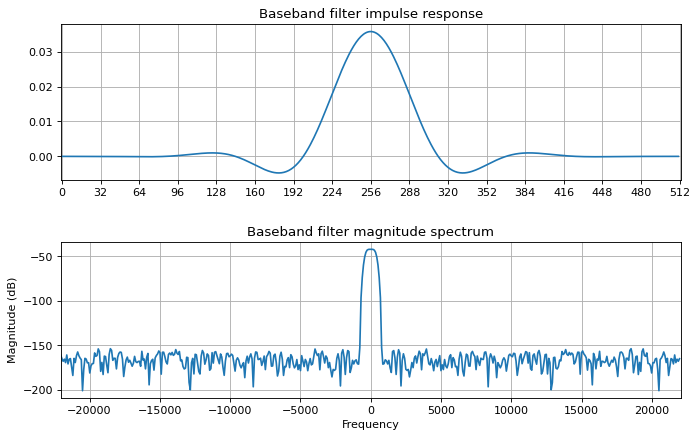

In [6]:
# Plotting the filter impulse and frequency response
fig = newfigure(nsubplots=2)

# Impulse response
ax = format_axis(fig.axes[0], title='Baseband filter impulse response', plottype='indices')
ax.plot(baseband_filter)

# Magnitude spectrum
ax = format_axis(fig.axes[1], title='Baseband filter magnitude spectrum', plottype='spectrum',fs=fs)
ax.magnitude_spectrum(baseband_filter, Fs=fs, scale="dB", sides="twosided");

As it can be seen from the graph plots, with sampling frequency $f_s = 44.1$ kHz, the cutoff frequency of the baseband filter is around $f_s/64$ which means that using 32 equally spaced filters with bandwidth of $f_s/32$ will cover the entire spectrum.

Next we will create the filterbank by modulating the bandpass prototype filter. Each of the filters is centered on a odd multiple of $\pi/64$, so we calculate it by multiplying the bandpass prototype with a cosine of that frequency.

In [7]:
positivefreqaxis = np.linspace(0, params.fs/2, FFT_HALF)

filterbank = np.zeros((N_SUBBANDS,FRAME_SIZE), dtype='float32')

for sb in range(N_SUBBANDS):
    for n in range(FRAME_SIZE):
        filterbank[sb,n] = baseband_filter[n] * np.cos((2*sb + 1)*(n - 16) * np.pi/64)

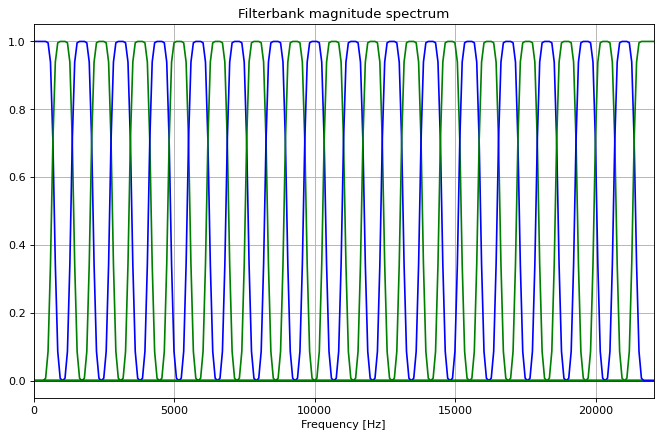

In [8]:
# Plotting the amplitude spectrum of the filterbank
fig = newfigure()
ax = format_axis(fig.axes[0], title='Filterbank magnitude spectrum', plottype='positivespectrum', fs=params.fs)

filterbank_amp_spectrum = np.transpose(np.abs(rfft(filterbank)))
ax.set_prop_cycle(color=['b','g'])
ax.plot(positivefreqaxis, filterbank_amp_spectrum);
plt.show()

### 3.2. Filtering the samples

Now that we have designed the filterbank and have the impulse response of all 32 filters, it is time to take a look on the actual filtering process.

MPEG-1 standard specifies a frame size of 512 audio samples for Layer 1 encoder. Filtering results with 32 times more subband samples than audio samples, so it is critically subsampled by a factor of 32. This process is shown in the following block diagram.

<img src="https://i.imgur.com/IMVIWlE.png" alt="Drawing" style="width: 40%;"/>

Although this would be a perfectly valid implementation, it would mean that we have to calculate the output for 32 filters of 512 samples for each new input audio sample, and then discard 31 out of 32 consecutive output samples from the filters by downsampling. Since this is obviously a very expensive way to do it, the subband filtering is performed in a different way by just slightly rearranging this diagram. We will use a shift size of 32 samples for the input audio frame (instead of "1 shift" when the filtering is done for each new sample), so the filtering will only be done each 32 input audio samples and no subsampling will be needed. Details about this can be found in [2].

Even this implementation is not the best one in terms of minimizing operations needed. ISO standard gives this implementation, which consists of windowing, calculating partials and modified DCT transformation. Details can also be found in [2]. We are not going to use it since it does not bring such a vast improvement in terms of speed and, more importantly, it is much more difficult to understand within the scope of this course.

Now let us look at the code for subband filtering. You can notice that there is a loop in `range(FRAMES_PER_BLOCK)`, which equals 12. The reason for that is because MPEG-1 Layer 1 specifies that 12 subsequent frames are processed and packed together as a block when being written to the output file.

The custom `WavRead` class enables us to read the desired number of samples in each iteration and appends it to the circular buffer. It returns number of samples read so that we can do the zero-padding when we reach the end of the file. The filtering itself can be done by a standard convolution or, equivalently, by reversing one signal and taking the dot product.

In [9]:
subband_samples = np.zeros((params.nch, N_SUBBANDS, FRAMES_PER_BLOCK), dtype='float32') 

# Processing is done for 12 subsequent frames
for frm in range(FRAMES_PER_BLOCK):
    # Read in next 32 samples
    samples_read = input_buffer.read_samples(SHIFT_SIZE)
    # Zero-pad the signal if EOF is reached
    if samples_read < SHIFT_SIZE:
        for ch in range(params.nch):
            input_buffer.audio[ch].insert(np.zeros(SHIFT_SIZE - samples_read)) 
        # Filtering = dot product with reversed buffer      
        for ch in range(params.nch):   
            subband_samples[ch,:,frm] = np.dot(filterbank, input_buffer.audio[ch].reversed()) 

It is also important to say that the subband filtering does not give perfect reconstruction. However, the error is very small and can be neglected compared to the error caused by the quantization of the samples, which will be discussed later.

## 4. Psychoacoustic model

The second part of the MP3 encoder is the psychoacoustic model. This is where different implementations of encoders differ in sound quality, as this part is not strictly specified by the standard. The model calculates how many bits to be assigned to each subband. After quantization, it makes no difference what method was used for bit allocation, as the decoder simply calculates the audio samples from the quantized subband samples.

The goal of MP3 encoding is to achieve high compression ratio while minimising the degradation of audio quality. This is not done by preserving the waveforms, but by exploiting some characteristics of the human auditory system. These characteristics are determined by listening tests where listeners subjectively grade audio quality, just-noticable-difference tests, where they are certain changes in the signal obsereved by the listeners, and some other psychoacoustic tests. These experiments enable us to design compression algorithms which exploit the characteristics of the human auditory system.

### 4.1. Masking effect

Here we will give a brief explanation of the masking effect: How it works, what are critical bands and why it is used in MP3 encoding.

As we've already mentioned, masking effect is a characteristic of the human auditory system detected by psychoacoustic tests. Humans are unable to distinguish between frequencies that are too close together: Only the stronger one is heard. We say that the stronger frequency is a <b>masker</b> and masks the weaker ones around it. The nearby frequencies that would be masked depend on the masking function of the masker. Masking function gives us a sound pressure level at each frequency nearby the masker below which the components will be inaudible. 

Let us show an example of the masking effect to explain this better. We will consider a signal which consists of three frequency components, the largest one at 8 kHz and two smaller ones at 7.6 Hz and 8.5 kHz.

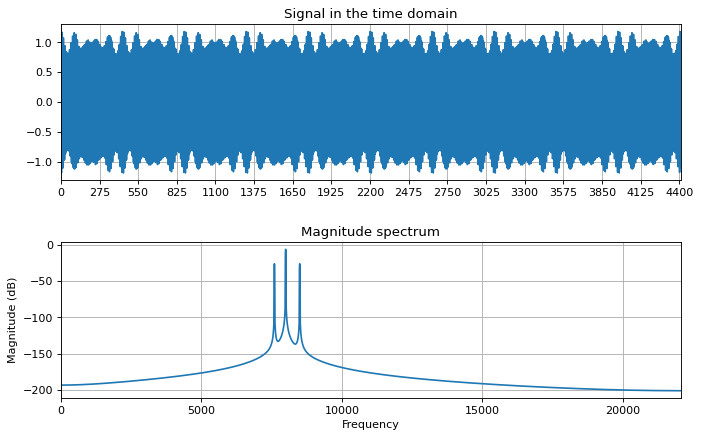

In [10]:
fs = params.fs
t = np.arange(0,0.1,1.0/fs)
y = np.sin(2*np.pi*8000*t) + 0.1*np.sin(2*np.pi*8500*t) + 0.1*np.sin(2*np.pi*7600*t)

fig = newfigure(nsubplots=2)

ax  = format_axis(fig.axes[0], title='Signal in the time domain', plottype='indices', xmax = len(y))
ax.plot(y);

ax  = format_axis(fig.axes[1], title='Magnitude spectrum', plottype='positivespectrum', fs=fs)
ax.magnitude_spectrum(y, Fs=fs, scale="dB");

Now we will see the masking effect that the strongest component has over the other two. In the following piece of code we find the index corresponding to the maximum value in the spectrum and calculate the masking function for it. Later in the psychoacoustic model the masking function calculation will be explained in detail. Now we just focus on the figures.

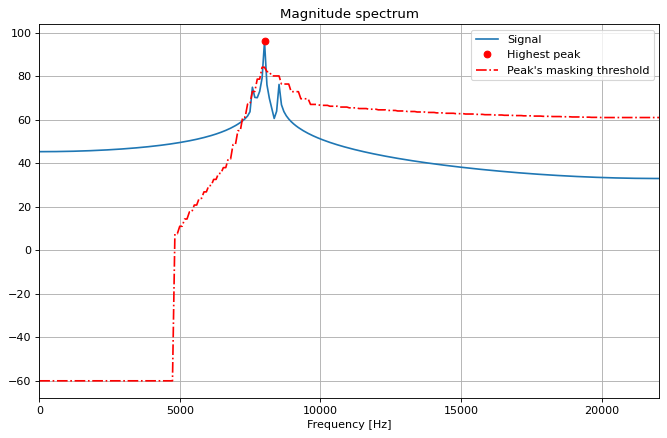

In [11]:
Y = np.abs(rfft(y,FFT_SIZE))
Y = 20*np.log10(Y+EPS)
Y += 96 - np.max(Y) # Normalization to 96dB due to values in the table
maxind = np.argmax(Y)
mask= masking_function_tonal(Y, maxind, params.table)

fig = newfigure()

ax  = format_axis(fig.axes[0], title='Magnitude spectrum', plottype='positivespectrum', fs=fs)
ax.plot(positivefreqaxis, Y, label="Signal");
ax.plot(positivefreqaxis[maxind], Y[maxind], 'ro', label="Highest peak");

ax.plot(positivefreqaxis, mask, 'r-.', label="Peak's masking threshold");
ax.legend(loc="best");

Everything under the masking function should be inaudible by human ears. In this example, we can only hear the lower two frequencies (7.6 and 8 kHz), and the higher one (8.5 kHz) is masked by the strongest one (8 kHz). Of course, this is just an estimate and cannot be considered absolutelly correct.

### 4.2. Critical bands

Another term closely related to masking in the psychoacoustic model is a critical band. A critical band is a frequency range in which human ear can only perceive one frequency. If another one appears in the same band, due to the masking effect, it is not audible.

The frequency ranges of critical bands are also determined by psycoacoustic tests. Let us show critical bands that we are going to use in the psychoacoustic model.

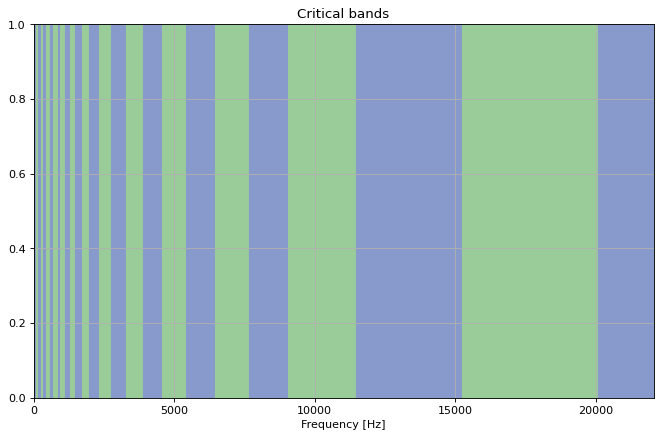

In [12]:
fig = newfigure()
ax  = format_axis(fig.axes[0], title='Critical bands', plottype='positivespectrum', fs=params.fs)


colors = ['#99cc99', '#8899cc']
cbands = get_critical_bands(params.table)
for cb in range(1,len(cbands)):
    ax.axvspan(params.fs*cbands[cb-1]/FFT_SIZE, params.fs*cbands[cb]/FFT_SIZE, color=colors[cb%len(colors)])

## 5. The *ISO psychoacoustic model 1*

In this section we will give a detailed look into the first of two psychoacoustic models proposed in the ISO MPEG-1 standard, and compare it to uniform quantization (where each subband gets equal number of bits). You are encouraged to make some changes to the model (or even implement one by yourself, for example, based on the signal power of each subband) and to listen to the effects on the encoded audio. Note that the differences are much more noticable at lower bitrates (e.g. 64 kbps).

The psychoacoustic model under investigation can be devided into several steps, described in the following subsections. 

### 5.1. Fourier analysis and finding sound pressure levels

The entire psychoacoustic model operates on the magnitude spectrum of the signal, so the first step is to perform Fourier analysis. In the subband filtering part we have read 384 (1 block = 12 * 32 = 384) new samples into a circular buffer of size 512. Fourier analysis on this buffer is by definition Short Time Fourier Transform (STFT) done with the rectangular window and shift size of 32 samples. However, Hann window (also known as Hanning window) is used rather than the rectangular window, so we must pre-multiply the buffer with the window. You can try using any other window but hearing the difference is probably be impossible. Right after the FFT we calculate the magnitude spectrum as all the subsequent processing will be done on magnitudes.

In [13]:
ch= 0 # processing the first channel (of possibly 2 - you can manually 
      # change this and do the processing for the second channel
      # or just run the function later which will do it for you)
        
X = np.abs(rfft(input_buffer.audio[ch].ordered() * params.table.hann) / FFT_SIZE)
X = 20 * np.log10(X + EPS)

# Scaling so that the maximum magnitude is 96 dB.
X+= 96 - np.max(X)

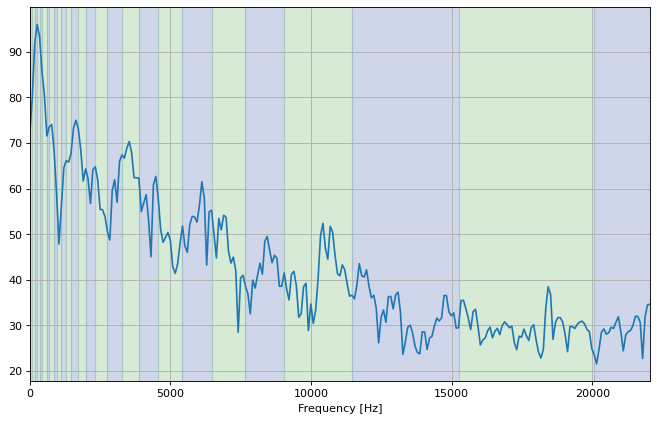

In [14]:
# Plotting the magnitude spectrum of the frame
fig = newfigure()
ax = format_axis(fig.axes[0], plottitle='Local magnitude spectrum of the audio signal', plottype='positivespectrum', fs=params.fs)

colors = ['#99cc99', '#8899cc']
cbands = get_critical_bands(params.table)
for cb in range(1,len(cbands)):
    ax.axvspan(params.fs*cbands[cb-1]/FFT_SIZE, params.fs*cbands[cb]/FFT_SIZE, color=colors[cb%len(colors)], alpha=.4)

ax.plot(positivefreqaxis, X);

Sound pressure level in each subband is calculated with the following formula:

$$spl(sb) = max(X[k]\in sb, 20*log_{10}(scf(sb)*32768)-10)$$

Here $spl(sb)\:$ denotes sound pressure level in band $sb$, $X[k]\:$ <i>k</i>-th bin in the magnitude spectrum and $scf(sb)\:$ scale factor for the corresponding subband. The scale factors will be explained in detail in the chapter concerning the quantization. For now it is enough to know that samples of the each band are scaled to use as much of the quantization range as possible.

In [15]:
# Finding the scale factors. This part will be explained later, 
# including why we are calculating the indices first.
scfindices = np.zeros((params.nch, N_SUBBANDS), dtype='uint8')
scfindices[ch,:] = get_scalefactors(subband_samples[ch,:,:], params.table.scalefactor)
scf = params.table.scalefactor[scfindices]

In [16]:
# Now we can calculate sound pressure level for each subband. 
# Note that we are ignoring the 0-th bin because it is the DC component.
subband_spl = np.zeros(N_SUBBANDS)
for sb in range(N_SUBBANDS):
    subband_spl[sb] = np.max(X[int(1 + sb * SUB_SIZE) : int(1 + sb * SUB_SIZE + SUB_SIZE)])
    subband_spl[sb] = np.maximum(subband_spl[sb], 20 * np.log10(scf[0,sb] * 32768) - 10)

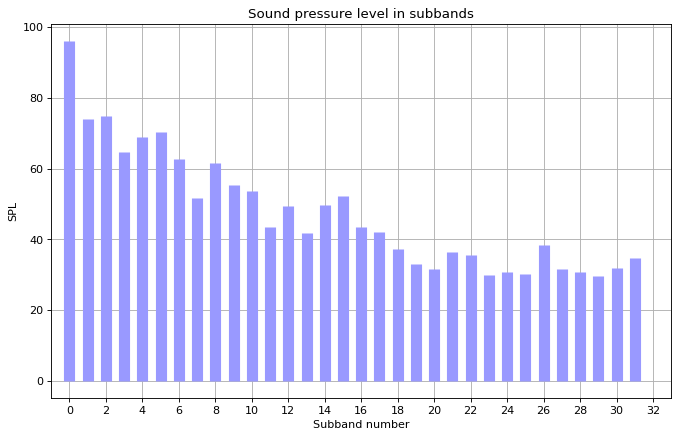

In [17]:
# Plotting the SPL
fig = newfigure()
ax = format_axis(fig.axes[0], title='Sound pressure level in subbands', plottype='indices', xmax=32)
ax.vlines(range(N_SUBBANDS), np.zeros(N_SUBBANDS), subband_spl, '#9999ff', linewidth=10);
ax.set_xlabel("Subband number");
ax.set_ylabel("SPL");

### 5.2. Finding tonal and non-tonal (noise) components

It is important to find the tonal and non-tonal (noise) components in the spectrum as they have different influence on the masking threshold. There are many methods for detecting tonal components in the spectrum, and most of them are similar. Here we follow the method in the ISO standard.

The first step is to find the peaks in the spectrum. One simple method is to highlight all the bins which are larger than their neighbours.

In [18]:
peaks = []
for i in range(2, int(FFT_SIZE/2 - 6)):  # Range will be expained below
    if X[i] >= X[i+1] and X[i] > X[i-1]:
        peaks.append(i)

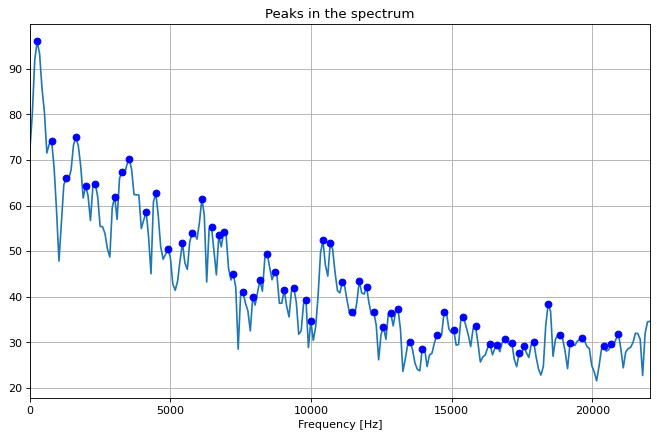

In [19]:
# Plotting peaks
fig = newfigure()
ax  = format_axis(fig.axes[0], title='Peaks in the spectrum', plottype='positivespectrum', fs=params.fs)
ax.plot(positivefreqaxis, X)
ax.plot(positivefreqaxis[peaks], X[peaks], 'bo');

The graph above shows us a some strong peaks and many weak ones which are not tonal. The identification of tonal components from the peaks is done by comparing the magnitude of the bin by its neighbouring bins. Actually, immediate neighbours are not considered since the were already used in the previous step; only bins with offset 2 or more are considered. Lower bins ($2<k<63\:$) are compared to two bins, middle ($63<=k<127\:$) to four of them and higher ($127<=k<250\:$) to ten bins.

For identifying tonal components we use a simple class that keeps track of tonality and stores lists of tonal and non-tonal components. Instead of keeping just the magnitude of the peak bin, sound pressure level of the tonal component is calculated as the magnitude sum of the bin and its two immediate neighbours.

In [20]:
tonal = psychoacoustic.TonalComponents(X)
tonal.flag[0:3] = IGNORE

table = params.table
    
for k in peaks:
    is_tonal = True
    if k > 2 and k < 63:
        testj = [-2,2]
    elif k >= 63 and k < 127:
        testj = [-3,-2,2,3]
    else:
        testj = [-6,-5,-4,-3,-2,2,3,4,5,6]
    for j in testj:
        if tonal.spl[k] - tonal.spl[k+j] < 7:
            is_tonal = False
            break
    if is_tonal:
        tonal.spl[k] = add_db(X[k-1:k+2])
        tonal.flag[k + np.arange(testj[0], testj[-1] + 1)] = IGNORE
        tonal.flag[k] = TONE
        tonal.tonecomps.append(k)

Lets see which peaks were chosen as tonal components. The difference between tonal component marker and magnitude spectrum is caused by adding neighbouring components to obtain the tonal component magnitude.

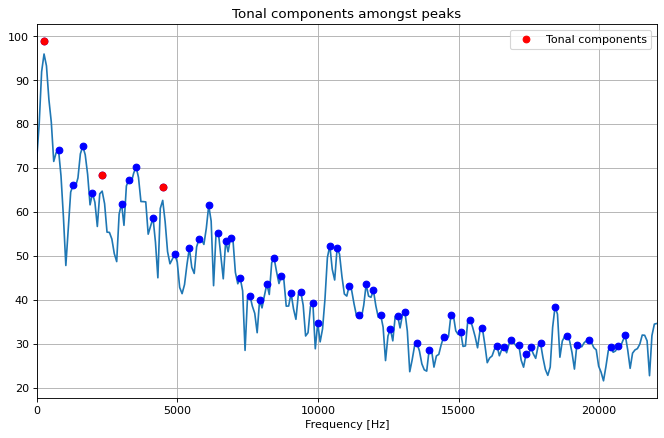

In [21]:
# Plotting tonal components selected from the peaks
fig = newfigure()
ax    = format_axis(fig.axes[0], title='Tonal components amongst peaks', plottype='positivespectrum', fs=params.fs)
ax.plot(positivefreqaxis, X);
ax.plot(positivefreqaxis[peaks], tonal.spl[peaks], 'bo');
ax.plot(positivefreqaxis[tonal.tonecomps], tonal.spl[tonal.tonecomps], 'ro', label="Tonal components");
ax.legend(loc="best");

Non-tonal components are calculated from the remaining bins. For each critical band magnitude sum of all remaining bins is calculated and stored as a non-tonal component at the bin closest to the geometric mean of the bins used.

In [22]:
for i in range(table.cbnum - 1):
    weight = 0.0
    msum = DBMIN
    for j in range(table.cbound[i], table.cbound[i+1]):
        if tonal.flag[i] == UNSET:
            msum = add_db((tonal.spl[j], msum))
            weight += np.power(10, tonal.spl[j] / 10) * (table.bark[table.map[j]] - i)
    if msum > DBMIN:
        index    = weight / np.power(10, msum / 10.0)
        center = table.cbound[i] + int(index * (table.cbound[i+1] - table.cbound[i])) 
        if tonal.flag[center] == TONE:
            center += 1
        tonal.flag[center] = NOISE
        tonal.spl[center] = msum
        tonal.noisecomps.append(center)

Let's now plot all the calculated components, all tonal and non-tonal for each critical band.

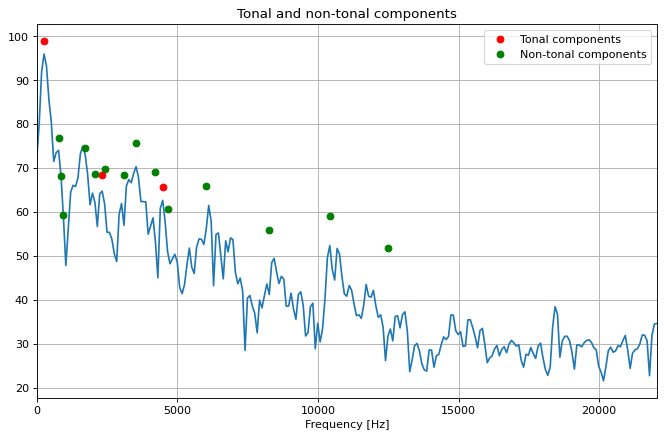

In [23]:
# Plotting tonal and non-tonal components selected from the peaks
fig = newfigure()
ax  = format_axis(fig.axes[0], title='Tonal and non-tonal components', plottype='positivespectrum', fs=params.fs)
ax.plot(positivefreqaxis, X);
ax.plot(positivefreqaxis[tonal.tonecomps ], tonal.spl[tonal.tonecomps ], 'ro', label="Tonal components");
ax.plot(positivefreqaxis[tonal.noisecomps], tonal.spl[tonal.noisecomps], 'go', label="Non-tonal components");
ax.legend(loc="best");

Some of those tonal and non-tonal components are below the minimum hearing threshold so they get discarded. Also, if two tonal components are too close to each other, the smaller one is discarded.

In [24]:
# Decimation of tonal and non-tonal components
# under the threshold in quiet
removed_tonal = []
removed_noise = []

for i in range(len(tonal.tonecomps)):
    if i >= len(tonal.tonecomps):
        break
    k = tonal.tonecomps[i]
    if tonal.spl[k] < table.hear[table.map[k]]:
        removed_tonal.append(tonal.tonecomps.pop(i))
        tonal.flag[k] = IGNORE
        i -= 1

for i in range(len(tonal.noisecomps)):
    if i >= len(tonal.noisecomps):
        break
    k = tonal.noisecomps[i]
    if tonal.spl[k] < table.hear[table.map[k]]:
        removed_noise.append(tonal.noisecomps.pop(i))
        tonal.flag[k] = IGNORE
        i -= 1

# Decimation of tonal components closer than 0.5 Bark
for i in range(len(tonal.tonecomps) - 1):
    if i >= len(tonal.tonecomps) - 1:
        break
    this = tonal.tonecomps[i]
    next = tonal.tonecomps[i+1]
    if table.bark[table.map[this]] - table.bark[table.map[next]] < 0.5:
        if tonal.spl[this] > tonal.spl[next]:
            tonal.flag[next] = IGNORE
            tonal.tonecomps.remove(next)
            removed_tonal.append(next)
        else:
            tonal.flag[this] = IGNORE
            tonal.tonecomps.remove(this)
            removed_tonal.append(this)

Let us see what components have survived, and where is the minimum hearing threshold.

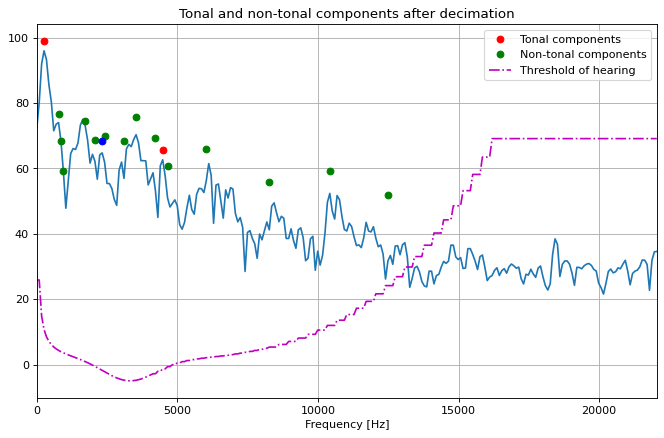

In [25]:
fig = newfigure()
ax  = format_axis(fig.axes[0], title='Tonal and non-tonal components after decimation', plottype='positivespectrum', fs=params.fs)
ax.plot(positivefreqaxis, X);
ax.plot(positivefreqaxis[tonal.tonecomps ], tonal.spl[tonal.tonecomps ], 'ro', label="Tonal components");
ax.plot(positivefreqaxis[tonal.noisecomps], tonal.spl[tonal.noisecomps], 'go', label="Non-tonal components");
ax.plot(positivefreqaxis[removed_tonal], tonal.spl[removed_tonal], 'bo');
ax.plot(positivefreqaxis[removed_noise], tonal.spl[removed_noise], 'bo');

minhear = hear_mapping(table.hear,table.map)
ax.plot(positivefreqaxis, minhear, 'm-.', label="Threshold of hearing");
ax.legend(loc="best");

### 5.3. Calculation of masking thresholds

Now we can calculate the masking caused by all remaining tonal and non-tonal components. Masking functions (different for tonal and non-tonal components) are given to calculate the masking threshold at index <i>i</i> caused by a tonal or non-tonal component (masker) at index <i>j</i>. The masking function denotes how strong a component must be in the neighbourhood of the masker to be audible. It is not symmetric (which makes sense, since perception is different on lower and higher frequencies) and it decays with distance from the masker. Too reduce computational complexity effect of a masker at index <i>j</i> is calculated only for neighbouring indices located in the range of [$j-3,j+7\:$].

Also, the masking threshold isn't calculated for all 256 bins but for a number (around 100) of unequally spaced subbands. Because the frequency resolution of the human is much better at lower frequencies, lower subbands are actually consisted of single bins, while the subband width stretches with higher frequencies. To avoid confusion with the 32 subbands of the filterbank, we are going to refer to these subbands as the <i>psychobands</i>.

At the end of this step, we calculate the masking effect of tonal and non-tonal components to each of the subbands.

In [26]:
# Individual masking thresholds
masking_tonal = []
masking_noise = []

for i in range(table.subsize):
    masking_tonal.append(())
    zi = table.bark[i]
    for j in tonal.tonecomps:
        zj = table.bark[table.map[j]]
        dz = zi - zj
        if dz >= -3 and dz <= 8:
            avtm = -1.525 - 0.275 * zj - 4.5
            if dz >= -3 and dz < -1:
                vf = 17 * (dz + 1) - (0.4 * X[j] + 6)
            elif dz >= -1 and dz < 0:
                vf = dz * (0.4 * X[j] + 6)
            elif dz >= 0 and dz < 1:
                vf = -17 * dz
            else:
                vf = -(dz - 1) * (17 - 0.15 * X[j]) - 17
            masking_tonal[i] += (X[j] + vf + avtm,)

for i in range(table.subsize):
    masking_noise.append(())
    zi = table.bark[i]
    for j in tonal.noisecomps:
        zj = table.bark[table.map[j]]
        dz = zi - zj
        if dz >= -3 and dz <= 8:
            avnm = -1.525 - 0.175 * zj - 0.5
            if dz >= -3 and dz < -1:
                vf = 17 * (dz + 1) - (0.4 * X[j] + 6)
            elif dz >= -1 and dz < 0:
                vf = dz * (0.4 * X[j] + 6)
            elif dz >= 0 and dz < 1:
                vf = -17 * dz
            else:
                vf = -(dz - 1) * (17 - 0.15 * X[j]) - 17
            masking_noise[i] += (X[j] + vf + avnm,)

Before summing them all up, let us visualize the individual masking thresholds of all components.

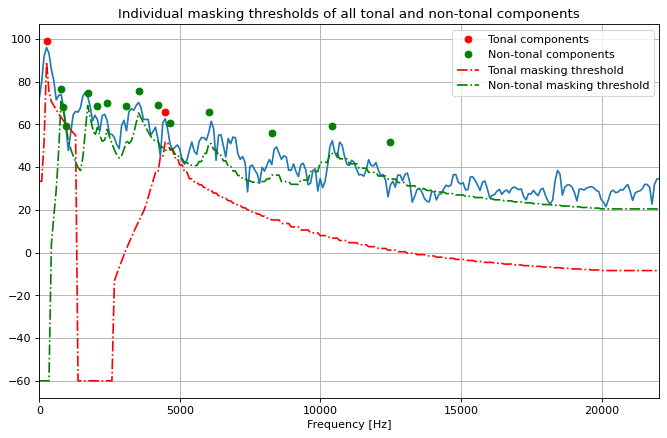

In [27]:
fig = newfigure()
ax  = format_axis(fig.axes[0], title='Individual masking thresholds of all tonal and non-tonal components', plottype='positivespectrum', fs=params.fs)
ax.plot(positivefreqaxis,X);
ax.plot(positivefreqaxis[tonal.tonecomps ], tonal.spl[tonal.tonecomps ], 'ro', label="Tonal components");
ax.plot(positivefreqaxis[tonal.noisecomps], tonal.spl[tonal.noisecomps], 'go', label="Non-tonal components");

maskthr_tonal = mask_mapping(masking_tonal, table.map)
maskthr_noise = mask_mapping(masking_noise, table.map)
ax.plot(positivefreqaxis, maskthr_tonal, 'r-.', label="Tonal masking threshold");
ax.plot(positivefreqaxis, maskthr_noise, 'g-.', label="Non-tonal masking threshold");
ax.legend(loc="best");

At this point we have the masking thresholds caused by tonal and non-tonal components in the spectrum, as well as minimum hearing thresholds from the table. To calculate total masking threshold in each of the psychobands we simply sum those up.

In [28]:
# Global masking thresholds
masking_global = []
for i in range(table.subsize):
    maskers = (table.hear[i],) + masking_tonal[i] + masking_noise[i]
    masking_global.append(add_db(maskers))

And the visualization of the global masking threshold.

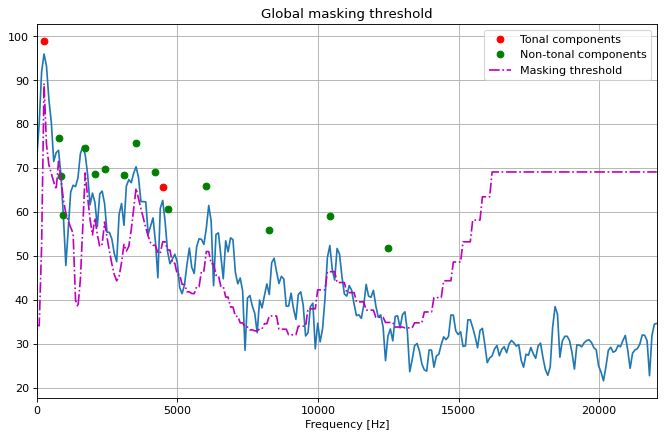

In [29]:
fig = newfigure()
ax    = format_axis(fig.axes[0],title='Global masking threshold',plottype='positivespectrum',fs=params.fs)
ax.plot(positivefreqaxis,X);
ax.plot(positivefreqaxis[tonal.tonecomps ], tonal.spl[tonal.tonecomps ],'ro', label="Tonal components");
ax.plot(positivefreqaxis[tonal.noisecomps], tonal.spl[tonal.noisecomps],'go', label="Non-tonal components");

maskthr_global = gmask_mapping(masking_global,table.map)
ax.plot(positivefreqaxis,maskthr_global,'m-.', label="Masking threshold");
ax.legend(loc="best");

Now we have masking thresholds in all of the psychobands, but those aren't the subbands which interst us for quantization - remember, we want to calculate masking effects in the 32 equally-spaced subbands for which we have calculated the samples. To do so, we must for all 32 subbands find the minimum threshold among all psychobands which belong to that subband.

In [30]:
# Minimum masking thresholds
mask = np.zeros(N_SUBBANDS)
for sb in range(N_SUBBANDS):
    first = table.map[int(sb*SUB_SIZE)]
    after_last = table.map[int((sb+1)*SUB_SIZE-1)]+1
    mask[sb] = np.min(masking_global[first:after_last])

Finally, as the last step in the psychoacoustic model, signal-to-mask ratio is calculated for each subband.

In [31]:
# Signal-to-mask ratio for each subband
smr = subband_spl-mask

The signal-to-mask ratio tells us what is the difference between sound pressure level and masking threshold in each subband and will be used to calculate subband bit allocation. It is used in the bit allocation process in the following way.

## 6. Bit allocation

Mask-to-noise ratio is calculated by subtracting the signal-to-noise ratio from the signal-to-mask ratio. The latter depends on the number of bits used for quantization. As the bit allocation process is iterative, at the beginning 0 bits are allocated to each channel.

The way we use mask-to-noise ratio is as follows. We locate the subband with the smallest MNR, allocate one more bit to it and calculate new MNR for that subband. We are always choosing the subband with smallest MNR because it means that the masking in that channel is the weakest and more noise is going to be audible, and therefore more bits are necessary to encode the signals to preserve sound quality. The code for this is rather straight-forward.

In [32]:
subband_bit_allocation = np.zeros((params.nch,N_SUBBANDS),dtype='uint8')
subband_bit_allocation[ch,:] = psychoacoustic.smr_bit_allocation(params,smr)

Let us now look at the difference between the bit allocation of psychoacoustic model with the uniform bit allocation. Calculating the uniform bit allocation is rather trivial, we use the psychoacoustic model bit allocation function, with input zeros instead of SMR.

In [33]:
uniform_bit_allocation = np.zeros((params.nch,N_SUBBANDS),dtype='uint8')
uniform_bit_allocation[ch,:] = psychoacoustic.smr_bit_allocation(params,np.zeros(N_SUBBANDS))

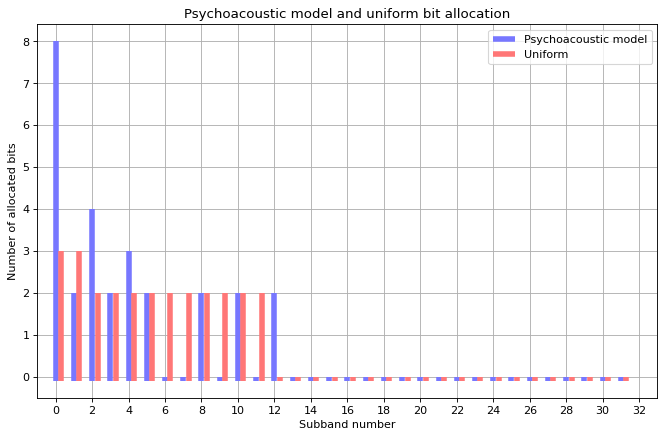

In [34]:
# Plotting the psychoacoustic model and uniform bit allocation
fig = newfigure()
ax = format_axis(fig.axes[0], title='Psychoacoustic model and uniform bit allocation', plottype='indices',xmax=32)
ax.vlines(np.arange(N_SUBBANDS)    , np.zeros(N_SUBBANDS)-0.1, subband_bit_allocation[ch,:], '#7777ff', linewidth=5, label="Psychoacoustic model");
ax.vlines(np.arange(N_SUBBANDS)+0.3, np.zeros(N_SUBBANDS)-0.1, uniform_bit_allocation[ch,:], '#ff7777', linewidth=5, label="Uniform");
ax.legend(loc="best");
ax.set_xlabel("Subband number");
ax.set_ylabel("Number of allocated bits");

You have probably noticed that the sum of all bits for uniform quantization is smaller. That is because assigning bits to a subband implies that we also have to assign the scaling factors for that subband, which is an extra 6 bits.

Now we have do do it again, if it is a stereo file, for the second channel. You can do it manually and look at the plots for the other channel or you can run the function below which will do it for you. If you decide to run the code in the notebook manually, be careful in the last step and do not overwrite the subband bit allocation array by declaring it again with `np.zeros`.

In [35]:
if (params.nch == 2):
    ch = 1
    subband_bit_allocation[ch,:] = psychoacoustic.model1(input_buffer.audio[ch].ordered(), params, scfindices)

## 7. Scaling and quantization

We have already talked about scaling in the psychoacoustic model as the scale factors were needed, but here we are going to explain it more  thoroughly.

Quantization of subband samples will be uniform, meaning that floating point numbers in the range $[-1,1)$ will be rounded to the nearest discrete quantization level and assigned the value between $-2^{n-1}$ (corresponding to -1) and $2^{n-1}-1$ corresponding to the highest level. To ensure maximum efficiency of such quantization, samples have to be scaled so that they use as much of the quantization range (and levels) as possible; otherwise we could end up using much less bits than what is available.

A standard way to perform quantization is to divide the signal with the greatest absolute value in it. If we would do so, it would be necessary to transmit a 32-bit scale factor for all the subbands, consuming huge amount of bandwidth. To avoid this, 16 predefined scale factors are used and only a 4-bit table index is sent for every subband.

### 7.1. Finding the scale factors and scaling

Remember that we are processing 12 subsequent frames in one block, meaning that in each subband, 12 subsequent samples will be scaled with the same scale factor. To find this scale factor, we simply look in the table and find the smallest value which is larger than the maximum absolute value among 12 samples, and repeat that for all subbands.

<img src="https://i.imgur.com/qUnSnjw.png" alt="Drawing" style="width: 40%;"/>

In [36]:
scfindices = np.zeros((params.nch,N_SUBBANDS),dtype='uint8')
for ch in range(params.nch):
    scfindices[ch,:] = get_scalefactors(subband_samples[ch,:,:],params.table.scalefactor)

Since at this point we have the scale factor indices, we simply divide the subband samples by the scale factors.

In [37]:
for ind in range(FRAMES_PER_BLOCK):
    subband_samples[:,:,ind] /= params.table.scalefactor[scfindices]

### 7.2. Quantizaiton of subband samples

Now we are finally ready to quantize the samples. ISO standard gives a quantization function of a form $subsample = subsample*a+b$, where quantization coefficients $a\:$ and $b\:$ are given in a table and are dependent on number of bits allocated. After transforming the coefficients with this function, we simply quantize it by multiplying with $2^{n-1}\:$ (where n is number of bits) and truncating the result.

In [38]:
for ch in range(params.nch):
    for sb in range(N_SUBBANDS):
        if subband_bit_allocation[ch,sb] != 0:
            subband_samples[ch,sb,:] *= params.table.qca[subband_bit_allocation[ch,sb]-2]
            subband_samples[ch,sb,:] += params.table.qcb[subband_bit_allocation[ch,sb]-2]
            subband_samples[ch,sb,:] *= 1<<subband_bit_allocation[ch,sb]-1
                
# Since subband_samples is a float array, it needs to be cast to integers.
subband_samples_quantized = subband_samples.astype('uint32')

## 8. Bitstream formatting

We are almost done, just need to pack the data and append it to the encoded file. Since this part is not very interesting for DSP, we are just going to briefly explain the structure of the bitstream.

Each block in a bitstream starts with the 32-bit header which contains a 11-bit syncword (11 ones) and encoding parameters (bitrate, sampling frequency, number of channels etc.). After the header, bit allocations are transmitted, followed by scale factor indices. Finally, quantized subband samples are transmitted, with a small modification, Most Significant Bit (MSB) is inverted to prevent writing all ones which could be decoded as a syncword. Subband samples and scale factors are only transmitted for subbands which have non-zero numbers of bits allocated.

In [39]:
bitstream_formatting("../samples/saxophone.mp3",
                     params,
                     subband_bit_allocation,
                     scfindices,
                     subband_samples_quantized)

### 8.1. Encoding the rest of the file

At this point, you can return to the beginning of this notebook and manually do encoding for another block, or you can run the `encode` function which will encode the rest of the file. The file produced should be playable in any media player so you can compare it to the original file. 

The fourth argument of the <b>encode</b> function denotes wheather you want to create another MP3 file with uniform quantization. This is for you to compare it to the one using the psychoacoustic model to calculate the bit allocation, and hear the difference in sound quality. 

In [40]:
encode(input_buffer, params, "../samples/saxophone.mp3", uniform=True)

The size of the raw audio file, saxophone.wav, is 92 KB. After MP3 encoding, the file size of the encoded file, saxophone.mp3, is only 8 KB. A compression ratio of 11.5 is achieved! Of course, such a high compression ratio comes with a price, you are invited to hear the loss of sound quality. Check the `samples` folder to discover the generated *.mp3* file! 

## 9. References
-  [1] Prandoni, Paolo; Vetterli, Martin : Signal Processing for Communications, <http://www.sp4comm.org/getit.html>
-  [2] Schniter, Phil : <https://cnx.org/contents/tjhwKF71@2.1:Jo7kdJOz@2/MPEG-Layers-1-3-Cosine-Modulated-Filterbanks> accessed 1 Apr 2021.